# Robust Constrained Embedding

In a [previous notebook](https://nbviewer.jupyter.org/github/fimrie/ConstrainedEmbedding/blob/master/constrained_embedding.ipynb), I discussed the RDKit function `AllChem.ConstrainedEmbed()`, which generates conformations where the positions of a set of atoms are constrained to match the coordinates of a template molecule.

There I discussed how to use the RDKit function `ConstrainedEmbed` and examined the energies of the conformation produced. In addition, I demonstrated two distinct strategies for ensuring the conformers are not strained (according to your favourite force field).

Unforunately, using `ConstrainedEmbed` with two distinct fragments, rather than a single connected subcomponent, is relatively brittle and results in conformers not able to be generated.

In this notebook, I will describe a method that is more robust to changes in the core of a molecule but still allows good 3D alignment at energies similar to unconstrained conformer generation.

### Requirements

The majority of this notebook uses rdkit and numpy only. At the end we will use py3Dmol to visualise some of the conformers. If you want to install this then skip this part/just look at our pretty pictures.

In [1]:
import numpy as np

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)

from utils import *

2018.09.1


We're going to use a different example to last time. This is a synthetic example based on [PDB ID 3ARP](https://www.rcsb.org/structure/3ARP), a complex of dequalinium with chitinase A,<sup>1</sup>. 

We have 'snipped up' the molecule into two fragments and a linker, as you can see below.

[1. Pantoom, S. et al., Potent family-18 chitinase inhibitors: x-ray structures, affinities, and binding mechanisms, J. Biol. Chem., 2011, 286, 24312-24323.](http://www.jbc.org/content/286/27/24312)

Cc1cc(N)c2ccccc2[n+]1CCCCCCCCCC[n+]1c(C)cc(N)c2ccccc21
11


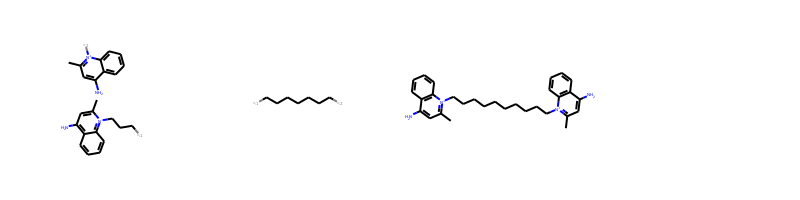

In [3]:
# 3ARP
deq_frags = "Cc1cc(N)c2ccccc2[n+]1CCC[*:1].[*:2][n+]1c(C)cc(N)c2ccccc21"
deq_linker = "[*:1]CCCCCCC[*:2]"
deq_3ARP = [x for x in Chem.SDMolSupplier("./3ARP_pdb_ligands.sdf")][0]
print(Chem.MolToSmiles(deq_3ARP))
print(Chem.rdMolDescriptors.CalcNumRotatableBonds(deq_3ARP))
deq_3ARP_2d = Chem.Mol(deq_3ARP)
_ = AllChem.Compute2DCoords(deq_3ARP_2d)

deq_3ARP_noinfo = Chem.MolToSmiles(deq_3ARP)

to_display = [Chem.MolFromSmiles(deq_frags), Chem.MolFromSmiles(deq_linker), deq_3ARP_2d]

Draw.MolsToGridImage(to_display,molsPerRow=4)

Now let's get the 3D coordinates of the fragments, as these are what we want to compare our conformers of the full molecule to and the atoms we will use for our constrained embedding. We'll use a custom function `get_frags`, that accounts for multiple possible matches of the starting fragments.

Once we've done this, let's check the alignment.

In [4]:
du = Chem.MolFromSmiles('*')
clean_frag = Chem.RemoveHs(AllChem.ReplaceSubstructs(Chem.MolFromSmiles(deq_frags),du,Chem.MolFromSmiles('[H]'),True)[0])
frags_3d = get_frags(deq_3ARP, clean_frag)

RDKit WARNING: [18:50:01] WARNING: not removing hydrogen atom without neighbors


In [5]:
rms = AllChem.AlignMol(frags_3d,deq_3ARP)
print("RMS: %.3f" % rms)
Chem.SanitizeMol(frags_3d)
Chem.SanitizeMol(deq_3ARP)

RMS: 0.000


rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

## Conformer generation

As before, we could generate conformers a look at the similarity to the active conformation and various energies. 

However, what if we're interested in a molecule that is <i>almost</i> the same, but with a one atom shorter linker.

10


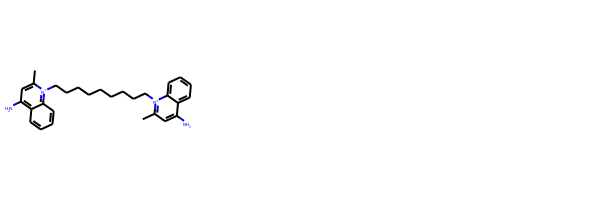

In [6]:
candidate_mol = Chem.MolFromSmiles("Cc1cc(N)c2ccccc2[n+]1CCCCCCCCC[n+]1c(C)cc(N)c2ccccc21")

print(Chem.rdMolDescriptors.CalcNumRotatableBonds(candidate_mol))

Draw.MolsToGridImage([candidate_mol])

### Unconstrained conformer generation

As before let's see how good conformer generation is when we impose no additional constraints on the embedding. Note that in our assessment we can't compare directly to the active conformation of the original molecule, but only the position of the fragments.

The molecule has ten rotatable bonds, so we should use 200 conformers to be confident of a reasonable answer<sup>1</sup>.
    
[1. Ebejer et al., Freely Available Conformer Generation Methods: How Good Are They? J. Chem. Inf. Model. 2012, 52, 1146–1158.](https://pubs.acs.org/doi/abs/10.1021/ci2004658)

In [7]:
num_confs = 200 # Use 50 if this is too slow.

In [8]:
rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, num_confs)]:
    # Generate conformer
    nm = Chem.Mol(candidate_mol)
    nm = Chem.AddHs(nm)
    AllChem.EmbedMolecule(nm,randomSeed=seed)
    AllChem.UFFOptimizeMolecule(nm)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)
    
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_frags == min(rms_frags_list):
        best_unconstrained = Chem.Mol(nm)
        best_unconstrained.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

RMS Fragments	- Mean: 2.35,	Min: 1.21,	Max: 4.36
Energy		- Mean: 93.3,	Min: 89.4,	Max: 103.5


A best RMSD of 1.21 Angstoms suggests that the candidate compound could be suitable to maintain the binding pose of the fragments. However, can it make a closer match?

### Constrained Embedding

As before, let's see if a constrained embedding will help us.

In [9]:
rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, num_confs)]:
    # Generate conformer
    nm = Chem.Mol(candidate_mol)
    nm = Chem.AddHs(nm)
    AllChem.ConstrainedEmbed(nm,frags_3d,randomseed=seed)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap) # Note we could access this directly with rms_frags = float(nm.GetProp('EmbedRMS'))
    
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_frags == min(rms_frags_list):
        best_constrained = Chem.Mol(nm)
        best_constrained.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

RDKit WARNING: [18:50:41] Could not triangle bounds smooth molecule.


ValueError: Could not embed molecule.

As mentioned before, the `ConstrainedEmbed` function can be a little brittle. Just removing a single carbon makes the initial embedding fail.

## Rough Constrained Embed

To solve this, we propose the new function, `RoughConstrainedEmbed`. This works very similarly to `ConstrainedEmbed`, but allows for more tolerence when performing the intial embedding. This procedure can still fail (as we will see later), but allows non-identical molecules to be embedded with constrains much more often than with `ConstrainedEmbed`.

The code is based heavily on `ConstrainedEmbed`, but incorporates the additional parameter `tdist` introduced in the previous notebook. The difference in the procedure is that instead of constraining the atoms on the initial embedding, we generate an arbitrary initial embedding, and then optimise the conformer with the additional distance constraints. 

In [10]:
def RoughConstrainedEmbed(mol, core, tdist=0.25, randomseed=2342,
                          getForceField=AllChem.UFFGetMoleculeForceField, **kwargs):
    """ generates an embedding of a molecule where part of the molecule
    is constrained to have particular coordinates
    Arguments
      - mol: the molecule to embed
      - core: the molecule to use as a source of constraints
      - randomSeed: (optional) seed for the random number generator
    """
    match = mol.GetSubstructMatch(core)
    if not match:
        raise ValueError("molecule doesn't match the core")

    ci = AllChem.EmbedMolecule(mol, randomSeed=randomseed, **kwargs)
    if ci < 0:
        raise ValueError('Could not embed molecule.')

    algMap = [(j, i) for i, j in enumerate(match)]

    # rotate the embedded conformation onto the core:
    rms = AllChem.AlignMol(mol, core, atomMap=algMap)
    ff = getForceField(mol, confId=0)
    conf = core.GetConformer()
    for i in range(core.GetNumAtoms()):
        p = conf.GetAtomPosition(i)
        pIdx = ff.AddExtraPoint(p.x, p.y, p.z, fixed=True) - 1
        ff.AddDistanceConstraint(pIdx, match[i], 0, tdist, 100.)
    ff.Initialize()
    n = 4
    more = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
    while more and n:
        more = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
        n -= 1
    # realign
    rms = AllChem.AlignMol(mol, core, atomMap=algMap)
    mol.SetProp('EmbedRMS', str(rms))
    return mol

As before, let's explore this procedure across a range of values for `tdist`. To speed things up, we'll only generate 50 conformers, rather than 200 as we did above.

In [11]:
print("50 conformers\n")

for dist in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    print("DIST: ", dist)
    rms_frags_list = []
    cenergy_list = []

    np.random.seed(seed=42)
    for seed in [int(x) for x in np.random.randint(1,100001, 50)]:
        # Generate conformer
        nm = Chem.Mol(candidate_mol)
        nm = Chem.AddHs(nm)
        RoughConstrainedEmbed(nm,frags_3d,randomseed=seed,tdist=dist)
        cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
        nm = Chem.RemoveHs(nm)
        
        # Anaylse conformer
        match = nm.GetSubstructMatch(frags_3d)
        if not match:
            raise ValueError("molecule doesn't match the core")
        algMap = [(j, i) for i, j in enumerate(match)]
        rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)

        rms_frags_list.append(rms_frags)
        cenergy_list.append(cenergy)
        
        # Record best for dist ==0.75
        if dist == 0.75:
            if rms_frags == min(rms_frags_list):
                best_constrained_flex = Chem.Mol(nm)
                best_constrained_flex.SetProp("Energy", "%.1f" % cenergy)

    print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
    print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))
    print()

50 conformers

DIST:  0.0
RMS Fragments	- Mean: 0.10,	Min: 0.07,	Max: 0.28
Energy		- Mean: 114.8,	Min: 101.4,	Max: 142.2

DIST:  0.1
RMS Fragments	- Mean: 0.14,	Min: 0.12,	Max: 0.29
Energy		- Mean: 108.6,	Min: 92.8,	Max: 129.1

DIST:  0.25
RMS Fragments	- Mean: 0.25,	Min: 0.21,	Max: 0.35
Energy		- Mean: 101.6,	Min: 91.4,	Max: 112.4

DIST:  0.5
RMS Fragments	- Mean: 0.44,	Min: 0.34,	Max: 0.49
Energy		- Mean: 98.3,	Min: 89.9,	Max: 118.5

DIST:  0.75
RMS Fragments	- Mean: 0.60,	Min: 0.49,	Max: 0.70
Energy		- Mean: 96.2,	Min: 88.5,	Max: 106.7

DIST:  1.0
RMS Fragments	- Mean: 0.75,	Min: 0.55,	Max: 0.96
Energy		- Mean: 94.9,	Min: 87.2,	Max: 113.5



As before, the conformers with small values of `tdist` have the best RMSDs, but the highest energies.

As we increase the value of `tdist` the RMSDs increase, but the energies decrease, exhibiting the desired behaviour.

Similarly to before, for all values of `tdist` of at least 0.5, the energies of the conformers is in line with the unconstrained conformer generation.

However, the RMSDs are substantially lower than the unconstrained case, despite generating 25% as many conformers.

This process can be made even more efficient, with limited impact on the generated conformers. 

Even when generating only 20 conformers, the 3D similarity is substantially better than when generating 200 in the unconstrained setting. Additionally, reducing the number of conformers generated from 50 to 20 doesn't substantially impact performance.

In [12]:
print("20 conformers\n")

for dist in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    print("DIST: ", dist)
    rms_frags_list = []
    cenergy_list = []

    np.random.seed(seed=42)
    for seed in [int(x) for x in np.random.randint(1,100001, 20)]:
        # Generate conformer
        nm = Chem.Mol(candidate_mol)
        nm = Chem.AddHs(nm)
        RoughConstrainedEmbed(nm,frags_3d,randomseed=seed,tdist=dist)
        cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
        nm = Chem.RemoveHs(nm)
        
        # Anaylse conformer
        match = nm.GetSubstructMatch(frags_3d)
        if not match:
            raise ValueError("molecule doesn't match the core")
        algMap = [(j, i) for i, j in enumerate(match)]
        rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)

        rms_frags_list.append(rms_frags)
        cenergy_list.append(cenergy)

    print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
    print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))
    print()

20 conformers

DIST:  0.0
RMS Fragments	- Mean: 0.09,	Min: 0.07,	Max: 0.27
Energy		- Mean: 114.1,	Min: 104.4,	Max: 128.5

DIST:  0.1
RMS Fragments	- Mean: 0.14,	Min: 0.12,	Max: 0.29
Energy		- Mean: 110.5,	Min: 98.7,	Max: 129.1

DIST:  0.25
RMS Fragments	- Mean: 0.25,	Min: 0.21,	Max: 0.35
Energy		- Mean: 101.3,	Min: 91.4,	Max: 112.0

DIST:  0.5
RMS Fragments	- Mean: 0.43,	Min: 0.34,	Max: 0.49
Energy		- Mean: 98.0,	Min: 92.1,	Max: 108.3

DIST:  0.75
RMS Fragments	- Mean: 0.61,	Min: 0.54,	Max: 0.69
Energy		- Mean: 96.3,	Min: 90.1,	Max: 106.7

DIST:  1.0
RMS Fragments	- Mean: 0.75,	Min: 0.59,	Max: 0.96
Energy		- Mean: 94.8,	Min: 87.2,	Max: 103.3



# Visualisation

Now let's visualise the best unconstrained conformer out of the 200 generated, as well as the best constrained conformer with `tdist==0.75` when sampling 50 conformers.

In [13]:
import py3Dmol

In [14]:
def drawit(ms, p=None, confId=-1):
        if p is None:
            p = py3Dmol.view(width=400, height=300)
        p.removeAllModels()
        for m in ms:
            mb = Chem.MolToMolBlock(m, confId=confId)
            p.addModel(mb, 'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

This is the active conformation extracted from the PDB, together with the energy of the conformer under the UFF force field.

In [15]:
print("Energy: %.1f" % AllChem.UFFGetMoleculeForceField(deq_3ARP).CalcEnergy())
drawit([deq_3ARP])

Energy: 113.6


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Let's look at the best conformer of the candidate molecule through the unconstrained conformer generation.

In [16]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_unconstrained), best_unconstrained.GetProp("Energy")))
drawit((deq_3ARP, best_unconstrained))

RMS frags: 1.206, Energy: 92.5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's compare that to the best conformer generated during `RoughConstrainedEmbed`.

In [17]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_constrained_flex), best_constrained_flex.GetProp("Energy")))
drawit((deq_3ARP, best_constrained_flex))

RMS frags: 0.492, Energy: 99.5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Failure case

If we now consider a more radical change to the ligand, how will this affect our process?

We consider the same analysis, this time having removed six carbon atoms from the linker, reducing the linker length from seven carbons in the original fragmentation of dequalinium, to just one now. This molecule definitely should not be able to adopt a 3D conformation that is highly similar to dequalinium.

5


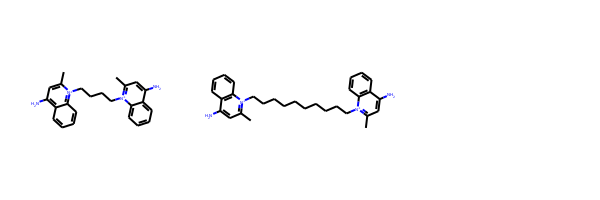

In [18]:
candidate_mol = Chem.MolFromSmiles("Cc1cc(N)c2ccccc2[n+]1CCCC[n+]1c(C)cc(N)c2ccccc21")

print(Chem.rdMolDescriptors.CalcNumRotatableBonds(candidate_mol))

Draw.MolsToGridImage([candidate_mol, deq_3ARP_2d])

In [19]:
print("Unconstrained generation\n")

rms_frags_list = []
cenergy_list = []

np.random.seed(seed=42)
for seed in [int(x) for x in np.random.randint(1,100001, 50)]:
    # Generate conformer
    nm = Chem.Mol(candidate_mol)
    nm = Chem.AddHs(nm)
    AllChem.EmbedMolecule(nm,randomSeed=seed)
    AllChem.UFFOptimizeMolecule(nm)
    cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
    nm = Chem.RemoveHs(nm)
    
    # Analyse conformer
    match = nm.GetSubstructMatch(frags_3d)
    if not match:
        raise ValueError("molecule doesn't match the core")
    algMap = [(j, i) for i, j in enumerate(match)]
    rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)
    
    rms_frags_list.append(rms_frags)
    cenergy_list.append(cenergy)
    
    # Record best
    if rms_frags == min(rms_frags_list):
        best_unconstrained = Chem.Mol(nm)
        best_unconstrained.SetProp("Energy", "%.1f" % cenergy)
    
print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))

Unconstrained generation

RMS Fragments	- Mean: 3.63,	Min: 3.12,	Max: 4.71
Energy		- Mean: 85.1,	Min: 83.8,	Max: 91.5


In [20]:
print("Rough Constrained Generation\n")

for dist in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    print("DIST: ", dist)
    rms_frags_list = []
    cenergy_list = []

    np.random.seed(seed=42)
    for seed in [int(x) for x in np.random.randint(1,100001, 50)]:
        # Generate conformer
        nm = Chem.Mol(candidate_mol)
        nm = Chem.AddHs(nm)
        RoughConstrainedEmbed(nm,frags_3d,randomseed=seed,tdist=dist)
        cenergy = AllChem.UFFGetMoleculeForceField(nm).CalcEnergy()
        nm = Chem.RemoveHs(nm)
        
        # Anaylse conformer
        match = nm.GetSubstructMatch(frags_3d)
        if not match:
            raise ValueError("molecule doesn't match the core")
        algMap = [(j, i) for i, j in enumerate(match)]
        rms_frags = AllChem.AlignMol(nm, frags_3d, atomMap=algMap)

        rms_frags_list.append(rms_frags)
        cenergy_list.append(cenergy)
        
        # Record best for dist ==0.75
        if dist == 0.75:
            if rms_frags == min(rms_frags_list):
                best_constrained_flex = Chem.Mol(nm)
                best_constrained_flex.SetProp("Energy", "%.1f" % cenergy)

    print("RMS Fragments\t- Mean: %.2f,\tMin: %.2f,\tMax: %.2f" % (np.mean(rms_frags_list), min(rms_frags_list), max(rms_frags_list)))
    print("Energy\t\t- Mean: %.1f,\tMin: %.1f,\tMax: %.1f" % (np.mean(cenergy_list), min(cenergy_list), max(cenergy_list)))
    print()

Rough Constrained Generation

DIST:  0.0
RMS Fragments	- Mean: 0.83,	Min: 0.83,	Max: 0.84
Energy		- Mean: 1576.5,	Min: 1564.9,	Max: 1650.9

DIST:  0.1
RMS Fragments	- Mean: 0.88,	Min: 0.87,	Max: 0.88
Energy		- Mean: 1483.7,	Min: 1473.9,	Max: 1548.6

DIST:  0.25
RMS Fragments	- Mean: 0.95,	Min: 0.95,	Max: 0.96
Energy		- Mean: 1348.5,	Min: 1338.3,	Max: 1414.3

DIST:  0.5
RMS Fragments	- Mean: 1.10,	Min: 1.09,	Max: 1.10
Energy		- Mean: 1140.2,	Min: 1124.8,	Max: 1227.4

DIST:  0.75
RMS Fragments	- Mean: 1.26,	Min: 1.25,	Max: 1.26
Energy		- Mean: 947.5,	Min: 936.4,	Max: 1020.6

DIST:  1.0
RMS Fragments	- Mean: 1.43,	Min: 1.42,	Max: 1.43
Energy		- Mean: 784.9,	Min: 771.4,	Max: 811.6



In [21]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_unconstrained), best_unconstrained.GetProp("Energy")))
drawit((deq_3ARP, best_unconstrained))

RMS frags: 3.116, Energy: 84.6


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
print("RMS frags: %.3f, Energy: %s" % (AllChem.AlignMol(frags_3d, best_constrained_flex), best_constrained_flex.GetProp("Energy")))
drawit((deq_3ARP, best_constrained_flex))

RMS frags: 1.251, Energy: 968.3


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The conformers are much more similar (I'd argue TOO similar), but clearly have unrealistic energies that could easily be filtered out, as is done in a normal conformer generation pipeline. 

Unfortunately, this does introduce an additional hyperparameter `tdist`, but this can be sensbily set (perhaps even dynamically) based on an comparison of the energies of conformers generated with `RoughConstrainedEmbed` and an unconstrained approach when the candidate molecule is identical to the molecule used to produce the fragmentation.

In practice, this also requires doing a small run of unconstrained conformer generation (e.g. 1-10 conformers) in order to determine a sensible minimum energy with which to filter conformers. Given the need to generate far fewer conformers using this method, this need not add to the overall computational burden.